In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gzip
import pickle
import random

#### Loading data

Using part of the code from the 'lecture_data' script, the train_loader is defined later on so we can adjust the batch_size to the used net.

In [2]:
data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')

train_data = torch.Tensor(data[0][0])
train_data_label = torch.Tensor(data[0][1])
val_data, val_data_label = zip(*random.sample(list(zip(data[0][0], data[0][1])), 200))
val_data, val_data_label = torch.Tensor(val_data), torch.Tensor(val_data_label)
test_data = torch.Tensor(data[1][0])
test_data_label = torch.Tensor(data[1][1])

train_dataset = torch.utils.data.TensorDataset(train_data, train_data_label)
test_dataset = torch.utils.data.TensorDataset(test_data, test_data_label)
val_dataset = torch.utils.data.TensorDataset(val_data, val_data_label)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

#### Visualise some data

Visualising some images with the corresponding label to check if all is good

In [3]:
def display_img(img, lab):
    lab = np.argmax(lab)
    plt.figure()
    plt.imshow(img.reshape((28, 28)), interpolation='nearest', cmap='binary')
    plt.title('label: ' + str(lab))

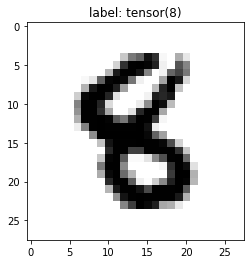

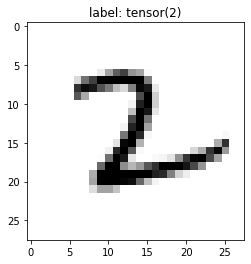

In [4]:
for i in range(2):
    display_img(test_data[i], test_data_label[i])

#### Building a linear network

Building a dynamic simple neural network.

The net is built with the features sizes of each layer indicated in the list f_s.

In [5]:
class LinearNet(nn.Module):
    def __init__(self, f_s, a):
        super(LinearNet, self).__init__()
        # Define the activation function
        self.act = a
        # Define an array that will hold the layers's Torch variables
        # So that PyTorch understands what's going on.
        # We first need to initialize the variables 
        # and then add them to the array for later use
        self.layers = []
        for i in range(len(f_s) - 1):
            # Initialise the Torch variable of the current layer
            exec('self.l_' + str(i) + ' = nn.Linear(f_s[' + str(i) + '], f_s[' + str(i + 1) + '])')
            # Add the new variable to the array
            exec('self.layers.append(self.l_' + str(i) + ')')
        
    def forward(self, x):
        # Goes through each layer in a feed forward manner
        # Gives the output through the activation function for 
        # every layer except for the last one
        for l in self.layers[:-1]:
            x = self.act(l(x))
        x = self.layers[-1](x)
        return x

#### Test with linear network

In [67]:
def predict(net):
    correct = 0
    total = 0
    with torch.no_grad():
        # Enumerate the whole testing set
        for d in test_loader:
            image, label = d
            # Get the net prediction
            output = net(image)
            total += 1
            # Add 1 if correct, 0 otherwise
            correct += int(np.argmax(output)) == int(np.argmax(label))
    # Return the accuracy of the net on the test data
    return correct / total

def val(net):
    correct = 0
    total = 0
    with torch.no_grad():
        # Enumerate the whole testing set
        for d in val_loader:
            image, label = d
            # Get the net prediction
            output = net(image)
            total += 1
            # Add 1 if correct, 0 otherwise
            correct += int(np.argmax(output)) == int(np.argmax(label))
    # Return the accuracy of the net on the test data
    return correct / total

def fit(net, optimizer, criterion):
    # For all epochs
    for e in range(epochs):
        # Enumerate the whole training set
        for i, d in enumerate(train_loader, 0):
            inputs, labels = d
            # Reset the parameters gradients
            optimizer.zero_grad()
            # Get the net prediction
            outputs = net(inputs)
            # Compute the loss
            loss = criterion(outputs, labels)
            # Back propagate the gradient
            loss.backward()
            optimizer.step()
            loss_h.append(float(loss))
            if i % 500 == 500 - 1 or (e == 0 and i == 50):
                acc_h.append(val(net))

In [68]:
# Parameters
learning_rate = .005
epochs = 2
# The array where we define the structure of the net
# We can add as many layers of any size as we want
features_sizes = [784, 128, 64, 10]
# Define the chosen activation function
activation_fn = torch.nn.Sigmoid()
# Define the chosen loss function
criterion = nn.MSELoss()

# Define the net and optimizer
linear_net = LinearNet(features_sizes, activation_fn)
optimizer = torch.optim.Adam(linear_net.parameters(), lr=learning_rate)

# Define the train_loader so that we can select a batch_size of size 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [69]:
# Fit the net
loss_h = []
acc_h = []

fit(linear_net, optimizer, criterion)

In [84]:
# Print the accuracy on the test set
acc = predict(linear_net)
print('Accuracy: ' + str(acc))

Accuracy: 0.9607142857142857


In [71]:
scaled_loss_h = []
s = 0
for i, l in enumerate(loss_h):
    s += l
    if i % 10 == 9:
        scaled_loss_h.append(s / 10)
        s = 0

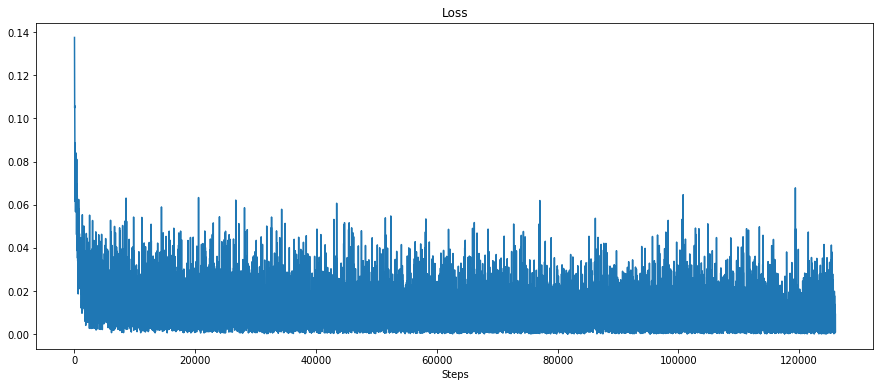

In [72]:
plt.title('Loss')
plt.plot([i * 10 for i in range(len(scaled_loss_h[:]))], scaled_loss_h[:], '-')
plt.xlabel('Steps')
plt.gcf().set_size_inches(15, 6)
plt.show()

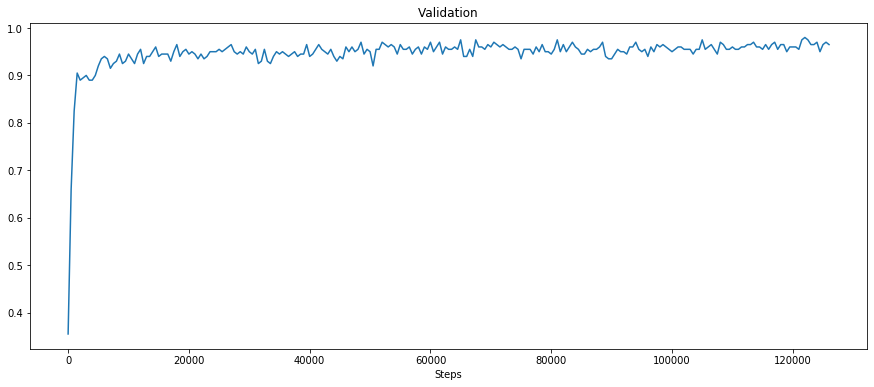

In [73]:
plt.title('Validation')
plt.plot([i * 500 for i in range(len(acc_h))], acc_h, '-')
plt.xlabel('Steps')
plt.gcf().set_size_inches(15, 6)
plt.show()

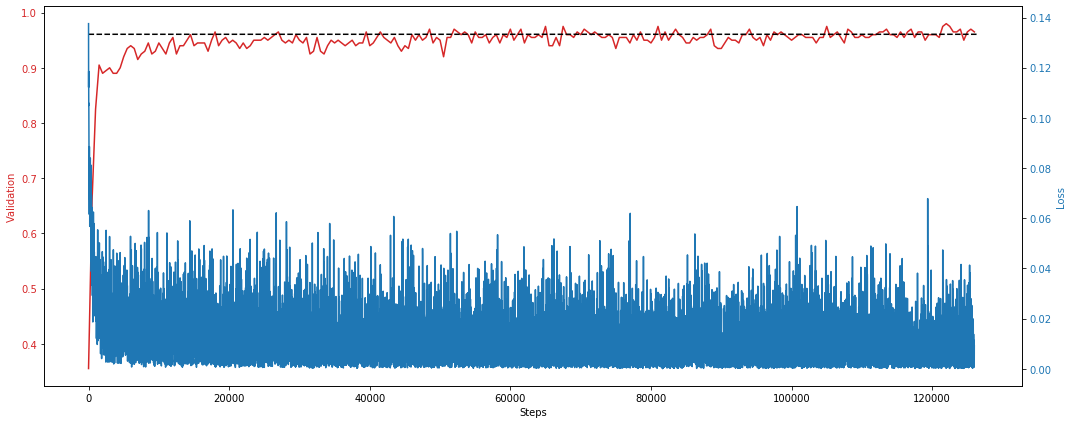

In [85]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Steps')
ax1.set_ylabel('Validation', color=color)
ax1.plot([i * 500 for i in range(len(acc_h))], acc_h, '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot([i * 10 for i in range(len(scaled_loss_h[:]))], scaled_loss_h[:], '-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.plot([acc] * len(acc_h) * 500, 'k--')
plt.gcf().set_size_inches(15, 6)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Building a convolutional network

We used the structure of an existing convolutional network :

https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

In [43]:
class ConvNet(nn.Module):
    def __init__(self, a):
        super(ConvNet, self).__init__()
        # Initialize Torch variable of the first conv layer
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Initialize Torch variable of the second conv layer
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Initialize Torch variable of max pooling layer
        # The point of this layer is to reduce the output dimension of the conv layers
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Initialize Torch variable of the two linear layers
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        # Add a dropout of 50%
        # Used to dropout 50% of the neurons of the fc layer 1
        self.dropout = torch.nn.Dropout(p=0.5)
        # Define the activation function
        self.act = a
        
    def forward(self, x):
        # conv, relu, max pool, conv, relu, max pool, fc, relu, dropout, fc
        x = self.conv_1(x)
        x = self.act(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.act(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [55]:
learning_rate = .001
epochs = 5
activation_fn = torch.nn.ReLU()
criterion = nn.MSELoss()

# Define the conv net and optimizer
conv_net = LinearNet(features_sizes, activation_fn)
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

# Batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

loss_h = []
acc_h = []

# Fit the net
fit(conv_net, optimizer, criterion)

In [56]:
# Print the accuracy on the test set
print('Accuracy: ' + str(predict(conv_net)))

Accuracy: 0.9752857142857143


In [57]:
scaled_loss_h = []
s = 0
for i, l in enumerate(loss_h):
    s += l
    if i % 10 == 9:
        scaled_loss_h.append(s / 10)
        s = 0

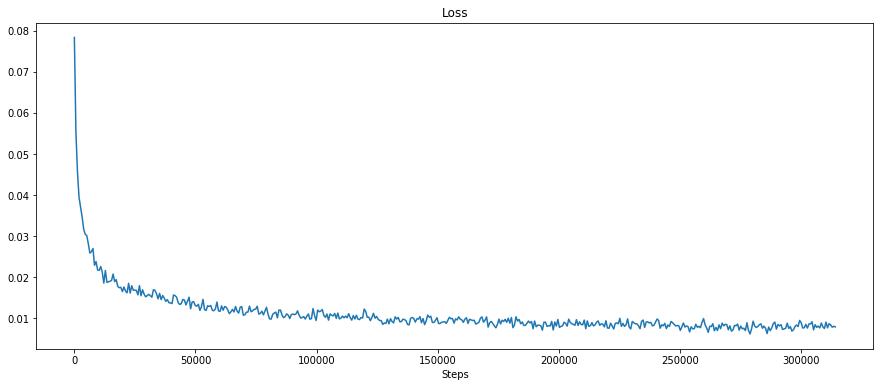

4925


In [62]:
plt.title('Loss')
plt.plot([i * 64 * 10 for i in range(len(scaled_loss_h))], scaled_loss_h, '-')
plt.xlabel('Steps')
plt.gcf().set_size_inches(15, 6)
plt.show()
print(len(loss_h))

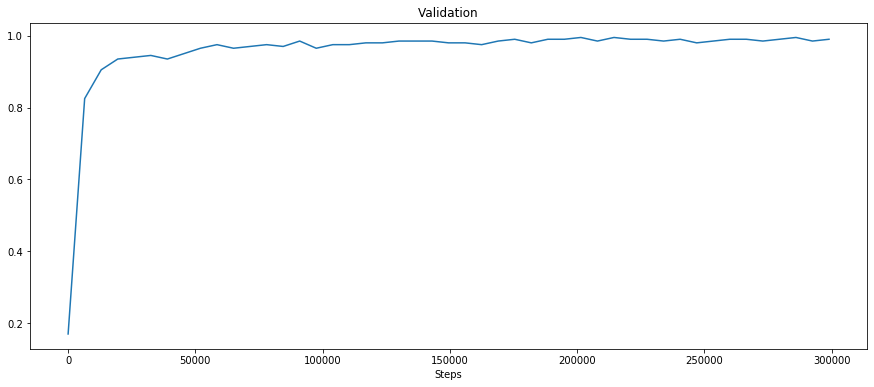

47


In [60]:
plt.title('Validation')
plt.plot([i * 100 * 65 for i in range(len(acc_h))], acc_h, '-')
plt.xlabel('Steps')
plt.gcf().set_size_inches(15, 6)
plt.show()
print(len(acc_h))